In [90]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt

In [91]:
# function to load the data files with the model and the betting vendor precitions for the last season
def load_data(file1, file2):
    model_data = pd.read_csv(file1) # loading of the dataset with the model predcitions
    betting_odds_data = pd.read_csv(file2) # loading of the dataset with the odd predictions
    return model_data, betting_odds_data

In [92]:
# function to translate the game results into numerical values
def convert_ftr(result: str):
    if result == "D":
        return 1
    elif result == "H":
        return 2
    elif result == "A":
        return 0
    else:
        return None

In [93]:
# function to only select the columns necessary for the comparison of our model and the betting vendors
# calling functions to harmonize the dataframes
def reduce_data(model_data, betting_odds_data):
    model_data_reduced = model_data[[
        'FTR', 'predictedResults', 'ProbAwayWin', 'ProbDraw', 'ProbHomeWin'
    ]]
    betting_odds_data_reduced = betting_odds_data[[
        'Betting_Prediction', 'Betting_Prediction_Probability', 'MaxHome', 'MaxAway', 'MaxDraw'
    ]]
    betting_odds_data_reduced[
        'Betting_Prediction'] = betting_odds_data_reduced[
            'Betting_Prediction'].apply(convert_ftr) # translation of the game results into numerical values
    betting_odds_data_reduced = betting_odds_data_reduced[-216:].reset_index() # only selecting the games from the last season
    return model_data_reduced, betting_odds_data_reduced

In [94]:
# function to get the probabilities for the result predicted from the model
def get_model_prediction_probability(model_data_reduced):
    result_probability = []
    z = 0
    while z < len(model_data_reduced): # loop to get the probability for the predicted result
        if model_data_reduced['predictedResults'][z] == 0:
            result_probability.append(model_data_reduced['ProbAwayWin'][z])
        if model_data_reduced['predictedResults'][z] == 1:
            result_probability.append(model_data_reduced['ProbDraw'][z])
        if model_data_reduced['predictedResults'][z] == 2:
            result_probability.append(model_data_reduced['ProbHomeWin'][z])
        z += 1
    return result_probability

In [95]:
def get_odd_prediction(data_model_reduced):
    erg_prob = []
    z = 0
    while z < len(data_model_reduced
                  ):  # loop to get the probability for the predicted result
        if data_model_reduced['predictedResults'][z] == 0:
            erg_prob.append(data_model_reduced['ProbAwayWin'][z])
        if data_model_reduced['predictedResults'][z] == 1:
            erg_prob.append(data_model_reduced['ProbDraw'][z])
        if data_model_reduced['predictedResults'][z] == 2:
            erg_prob.append(data_model_reduced['ProbHomeWin'][z])
        z += 1
    return erg_prob

In [96]:
# function to add the probabilities for the result predicted from the model to the dataframe
def add_model_probabilities(model_data_reduced):
    model_prediction_probability = get_odd_prediction(model_data_reduced)
    model_data_reduced[
        'Model_Prediction_Probability'] = model_prediction_probability # adding the probabilities for the predicted results to the dataframe
    return model_data_reduced

In [97]:
# function to merge the dataframes from the model and the betting odds
def merge_dataframes(model_data_reduced, betting_odds_data_reduced):
    data_for_evaluation = model_data_reduced[[
        'FTR', 'predictedResults', 'Model_Prediction_Probability'
    ]].merge(betting_odds_data_reduced[[
        'Betting_Prediction', 'Betting_Prediction_Probability', 'MaxHome', 'MaxAway', 'MaxDraw'
    ]],
             how='inner',
             left_index=True,
             right_index=True) # merging of the dataframes
    return data_for_evaluation

In [98]:
# function the get the number of the right picks from model, odds and only home team predictions
def get_evaluation_score(data_for_evaluation):
    right_model, right_odds, right_home = 0, 0, 0
    right_model_list, right_odds_list, right_home_list = [], [], []
    z = 0
    while z < len(data_for_evaluation):
        if data_for_evaluation['FTR'][z] == data_for_evaluation[
                'predictedResults'][z]:
            right_model += 1
        if data_for_evaluation['FTR'][z] == data_for_evaluation[
                'Betting_Prediction'][z]:
            right_odds += 1
        if data_for_evaluation['FTR'][z] == 2:
            right_home += 1
        right_model_list.append(right_model)
        right_odds_list.append(right_odds)
        right_home_list.append(right_home)
        z += 1

    return right_model, right_odds, right_home, right_model_list, right_odds_list, right_home_list

In [99]:
# function to print the accuracy for model, betting odds and only home team predictions
def print_accuracys(right_model, right_odds, right_home, data_for_evaluation):
    print('Accuracy Model: ', right_model / len(data_for_evaluation))
    print('Accuracy Odds: ', right_odds / len(data_for_evaluation))
    print('Accuracy Home: ', right_home / len(data_for_evaluation))

In [100]:
#  function to plot the number of the right picks over the last season
def show_right_picks(right_model_list, right_odds_list, right_home_list):
    default_fontsize = 30
    default_fontsize_ticks = 20
    x = np.linspace(0, 216, 216)

    y1 = right_model_list
    y2 = right_odds_list
    y3 = right_home_list

    plt.figure(num=3, figsize=(25, 12.5))
    plt.plot(x, y1, color='blue', linewidth=3.0, label='Model')
    plt.plot(x, y2, color='red', linewidth=3.0, label='Odds')
    plt.plot(x, y3, color='green', linewidth=3.0, label='Home')

    plt.xlabel("Number of Games", fontsize=default_fontsize)
    plt.ylabel("Right Predictions", fontsize=default_fontsize)
    plt.xticks(fontsize = default_fontsize_ticks)
    plt.yticks(fontsize = default_fontsize_ticks)
    plt.legend(fontsize = 25)
    plt.show()

In [101]:
# function to transfer the result probabilities into betting odds
def probability_to_odds(data_for_evaluation):
    z, model_odds, betting_odds = 0, 0, 0
    model_odds_list, betting_odds_list = [], []
    while z < len(data_for_evaluation):
        model_odds = 1 / (
            (data_for_evaluation['Model_Prediction_Probability'][z] * 100) /
            100)
        model_odds_list.append(model_odds)

        betting_odds = 1 / (
            (data_for_evaluation['Betting_Prediction_Probability'][z]) / 100)
        betting_odds_list.append(betting_odds)
        z += 1
    data_for_evaluation['Model_Odds'] = model_odds_list
    data_for_evaluation['Betting_Odds'] = betting_odds_list

In [102]:
# function to simulate betting with the model predcitions
def betting_with_the_model(data_for_evaluation):
    # print(data_for_evaluation.columns)
    z, model_bank = 0, 1000
    bank_model_list = []
    winning_team = "Home" if data_for_evaluation['predictedResults'][
                    z] == 'H' else "Draw" if data_for_evaluation['predictedResults'][
                    z] == 'D' else "Away"
    
    while z < len(data_for_evaluation):
        # compare_value = "Betting_Odds"
        compare_value = "Max" + winning_team
        if data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 40:
            model_bank = model_bank - 2
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                # model_bank = model_bank
                model_bank = model_bank + 2 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 70:
            model_bank = model_bank - 5
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                # model_bank = model_bank
                model_bank = model_bank + 5 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 80:
            model_bank = model_bank - 7
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank + 7 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 > 80:
            model_bank = model_bank - 10
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank + 10 * data_for_evaluation[compare_value][z]
        else:
            raise ValueError('Probability for betting must be between 0 and 1, but is' +\
            f"{data_for_evaluation['Model_Prediction_Probability'][z]}")
        bank_model_list.append(model_bank)
        z += 1
    return bank_model_list

In [103]:
# function to simulate betting with the betting odd predcitions
def betting_with_the_odds(data_for_evaluation):
    z, odds_bank = 0, 1000
    bank_odds_list = []

    winning_team = "Home" if data_for_evaluation['Betting_Prediction'][
                    z] == 'H' else "Draw" if data_for_evaluation['Betting_Prediction'][
                    z] == 'D' else "Away"
    
    while z < len(data_for_evaluation):
        # compare_value = "Betting_Odds"
        compare_value = "Max" + winning_team
        if data_for_evaluation['Betting_Prediction_Probability'][z] * 100 <= 40:
            odds_bank = odds_bank - 2
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                # odds_bank = odds_bank
                odds_bank = odds_bank + 2 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 <= 70:
            odds_bank = odds_bank - 5
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                # odds_bank = odds_bank
                odds_bank = odds_bank + 5 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 <= 80:
            odds_bank = odds_bank - 7
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank + 7 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 > 80:
            odds_bank = odds_bank - 10
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank + 10 * data_for_evaluation[compare_value][z]
        else:
            raise ValueError('Probability for betting must be between 0 and 1, but is' +\
            f"{data_for_evaluation['Model_Prediction_Probability'][z]}")
        bank_model_list.append(model_bank)
        bank_odds_list.append(odds_bank)
        z += 1
    return bank_odds_list

In [104]:
# fucntion to bet money on a game based on the probability for winning the game
# will bet 5 Euro, if the probability is 50 percent
def bet_with_given_prob(data_for_evalutation, betting_comparing_column, percentage_comparing_column, min_value_for_betting):
    odds_bank = 1000
    odds_bank_list = []
    bet_counter = 0
    for index, row in data_for_evalutation.iterrows():
        if row[percentage_comparing_column] >= min_value_for_betting:
            winning_team = "Home" if row['Betting_Prediction'] == 'H' \
                            else "Draw" if row['Betting_Prediction'] == 'D' else "Away"
            compare_value = "Max" + winning_team
            betting_sum = (row[percentage_comparing_column]*10)
            # betting_sum = (row[percentage_comparing_column]**2*10)
            odds_bank -= betting_sum
            if row[betting_comparing_column] == row['FTR']:
                odds_bank += row[compare_value] * betting_sum
            bet_counter += 1
        odds_bank_list.append(odds_bank)
    return odds_bank_list, bet_counter

In [105]:
# function to show the bank balance while the betting simulations
def simulate_betting_profit(bank_odds_list, bank_model_list):
    default_fontsize = 30
    default_fontsize_ticks = 20
    x = np.linspace(0, 216, 216)
    y = np.linspace(1000, 1000, 216)
    y1 = bank_odds_list
    y2 = bank_model_list

    plt.figure(num=3, figsize=(25, 12.5))
    plt.plot(x, y1, color='red', linewidth=3.0, label='Odds')
    plt.plot(x, y2, color='blue', linewidth=3.0, label='Model')
    plt.plot(x,
             y,
             color='black',
             linewidth=3.0,
             label='Baseline',
             linestyle='--')

    plt.xlabel("Number of Games", fontsize=default_fontsize)
    plt.ylabel("Money", fontsize=default_fontsize)
    plt.xticks(fontsize=default_fontsize_ticks)
    plt.yticks(fontsize=default_fontsize_ticks)
    plt.legend(fontsize=25)
    plt.show()

In [106]:
# function to get the accuracy and the plots with one click
def run_all(file1, file2, betting_prob=0.4, print_diagrams=True) -> dict:
    model_data, betting_odds_data = load_data(file1, file2)
    model_data_reduced, betting_odds_data_reduced = reduce_data(
        model_data, betting_odds_data)
    model_data_reduced = add_model_probabilities(model_data_reduced)
    data_for_evaluation = merge_dataframes(model_data_reduced,
                                           betting_odds_data_reduced)
    right_model, right_odds, right_home, right_model_list, right_odds_list, right_home_list = get_evaluation_score(
        data_for_evaluation)
    if print_diagrams:
        print_accuracys(right_model, right_odds, right_home, data_for_evaluation)
        show_right_picks(right_model_list, right_odds_list, right_home_list)
        probability_to_odds(data_for_evaluation)
    data_for_evaluation["Betting_Prediction_Probability"] = data_for_evaluation["Betting_Prediction_Probability"]/100
    bank_model_list, bet_counter_model = bet_with_given_prob(data_for_evaluation, "predictedResults", "Model_Prediction_Probability",betting_prob)
    bank_odds_list, bet_counter_odds = bet_with_given_prob(data_for_evaluation, "Betting_Prediction", "Betting_Prediction_Probability", betting_prob)
    # print(bet_counter_model, bet_counter_odds)
    if print_diagrams:
        # print(bank_model_list, bank_odds_list)
        simulate_betting_profit(bank_odds_list, bank_model_list)
    else:
        # only return the last element to get the result at the end of each season
        return {"BettingProb": betting_prob, "MoneyAtTheEndOdd": bank_odds_list[-1], 
                "MoneyAtTheEndModel": bank_model_list[-1], "madeBetsOdds": bet_counter_odds, 
                "madeBetsModel": bet_counter_model}



Accuracy Model:  0.5092592592592593
Accuracy Odds:  0.5046296296296297
Accuracy Home:  0.4583333333333333


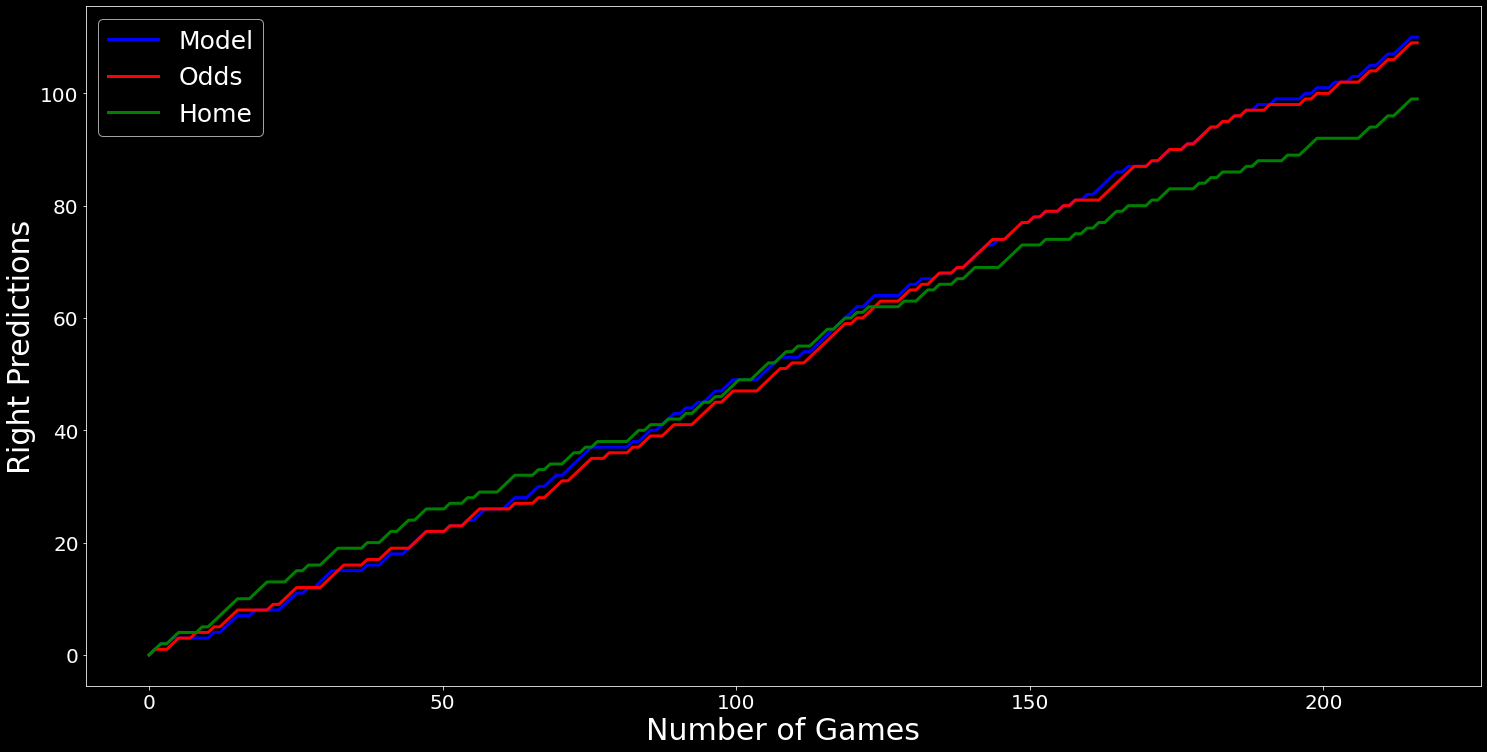

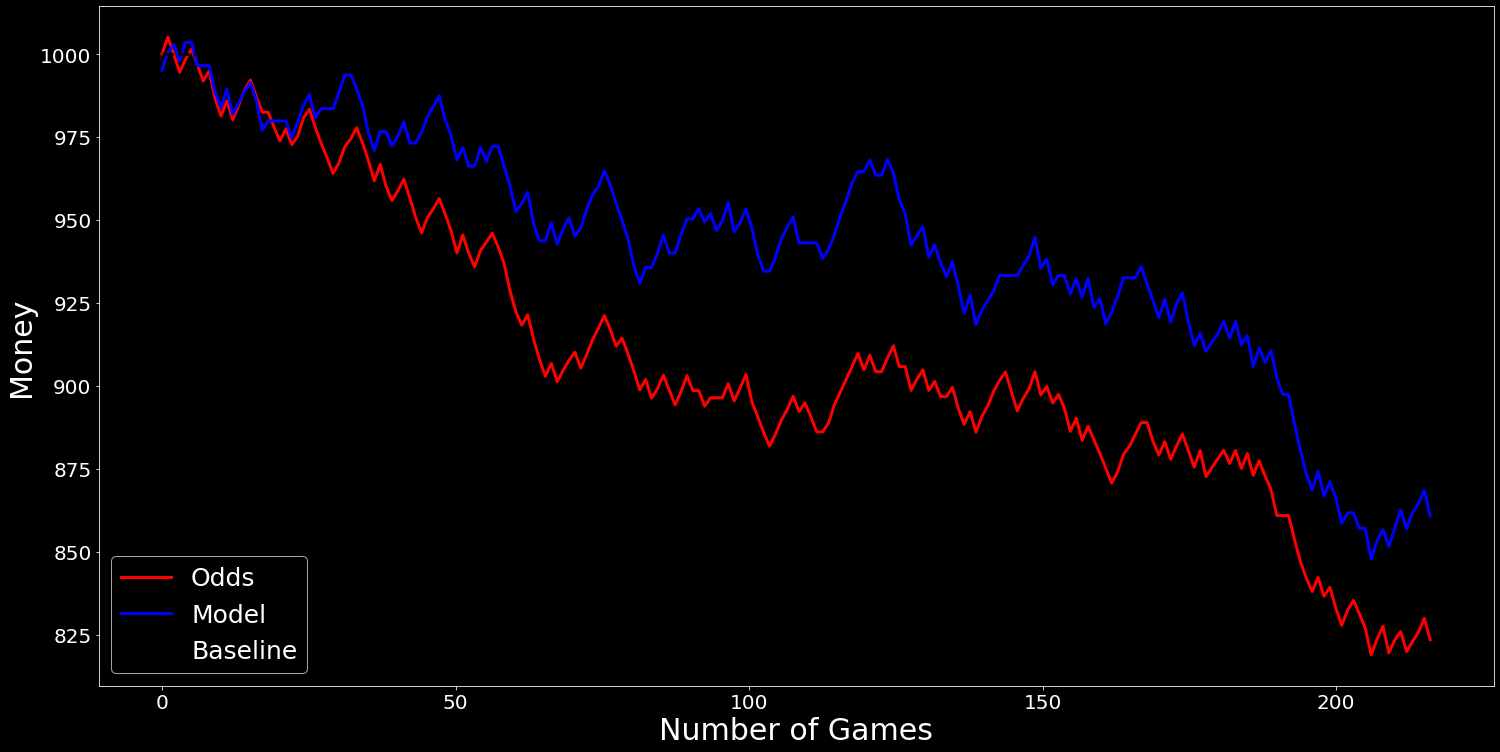

In [107]:
# calculate and plot betting for at least 40 % probability
file1 = 'Data\\match_data_predicted_bl_22.csv'
file2 = 'Data\\dataframe_with_odd_predictions_v2.csv'
run_all(file1, file2, betting_prob=0.4)

Accuracy Model:  0.5092592592592593
Accuracy Odds:  0.5046296296296297
Accuracy Home:  0.4583333333333333


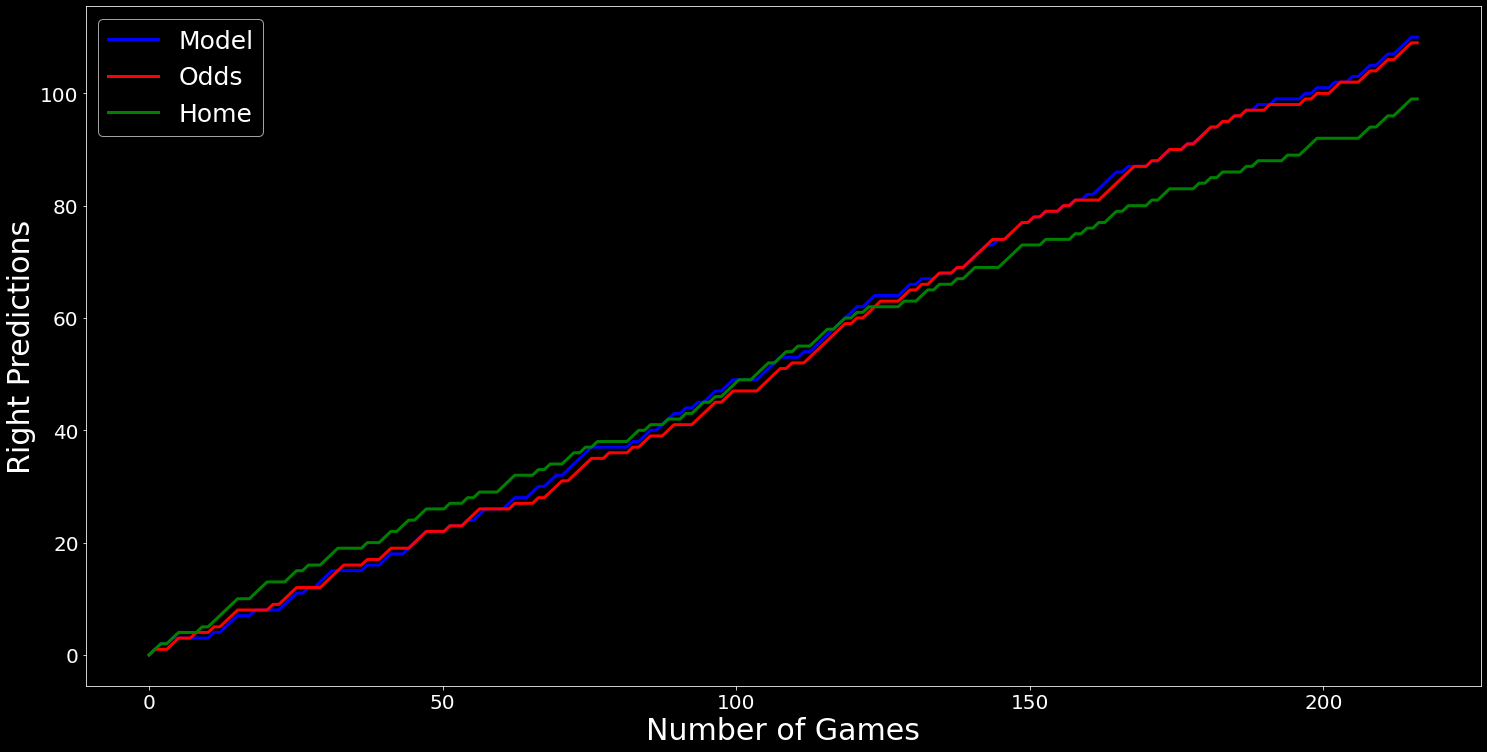

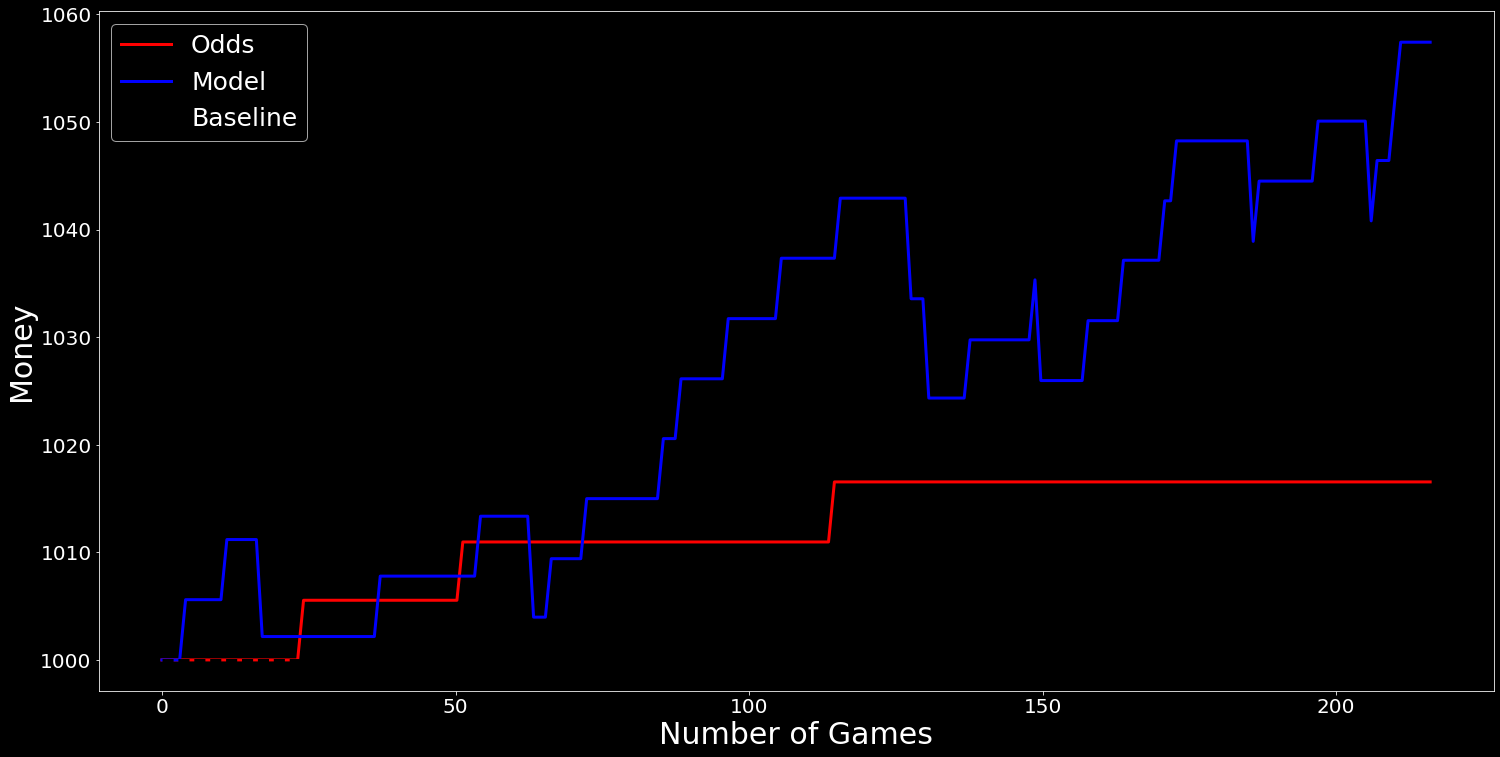

In [108]:
# calculate and plot betting for at least 90 % probability
run_all(file1, file2, betting_prob=0.9)

In [109]:
# simulate betting for different probabilities 
simulation = []
max_money_odds = {"BettingProb": 0, "MoneyAtTheEndOdd": 0, "madeBetsOdds": 0}
max_money_model = {"BettingProb": 0, "MoneyAtTheEndModel": 0, "madeBetsModel": 0}
for i in [0, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:
    list_values = run_all(file1, file2, betting_prob=i, print_diagrams=False)
    simulation.append(list_values)
    if max_money_odds["MoneyAtTheEndOdd"] < list_values["MoneyAtTheEndOdd"]:
        max_money_odds = list_values
    if max_money_model["MoneyAtTheEndModel"] < list_values["MoneyAtTheEndModel"]:
        max_money_model = list_values

In [110]:
# print maximum values
print(f'''Maximum Money at the end betting with Model: {max_money_model["MoneyAtTheEndModel"]}
    bets made: {max_money_model["madeBetsModel"]}, Probability for betting: {max_money_model["BettingProb"]}''')
print(f'''Maximum Money at the end betting with Odds: {max_money_odds["MoneyAtTheEndOdd"]}
    bets made: {max_money_odds["madeBetsOdds"]}, Probability for betting: {max_money_odds["BettingProb"]}''')

Maximum Money at the end betting with Model: 1057.4211501400007
    bets made: 29, Probability for betting: 0.9
Maximum Money at the end betting with Odds: 1058.9519922479662
    bets made: 58, Probability for betting: 0.65
